For imbalanced datasets, we have seen that we can use methods at the data level (Under-sampling and Over-sampling), cost-sensitive methods like higher miss-classification costs (where we add a cost in the cost function of the algorithms) and also ensemble algorithms, like bagging and boosting where we construct multiple learners from the data and we aggregate their predictions (but they usually optimize the global accuracy, not the imbalance class).

For imbalanced datasets, what has been done is to combine ensemble algorithms, like boosting and bagging, to a data level methods (like oversampling) or a cost-sensitive method.

The objective of Ensemble Learning is to improve model performance, and the idea is to combine several classifiers whose combination outperforms every individual counterpart. To do that, several classifiers are built from the data, and their decisions combined or aggregated.

To classify a new example, it is submitted to all the classifiers, and the prediction of all the classifiers are considered to make the final deicision, wether it is a Hard voting (majority of votes) or a Soft Voting (high % of belonging to one class).

The motivation to combine classifiers is to improve their generalization, because each classifier is know to make errors, but beause all the classifiers make different kind of errors, the missclassified examples will not be the same. Therefore, they are complimentary.

Bagging consists on creating different datasets by bootstrapping (creating data with samples from the data) with replacement the original data, then train a classifier on each boostramp sample and then combine the predictions either by average or majority vote. On a randomForest, we use decision tree to make the predictions where the number of features corresponds to a subsets of features (sqrt(n) usually). So to sum up, classifiers are built in parallel, and trained on subsamples of data, where every classifier has a similar weight towards the final prediction.

The injected randomness creates de-correlated, or de-couples classifiers which combined improves the overall generalization.

Off-the-shelf algorithms optimize the accuracy, which is not suitable for imbalanced datasets. We can use under or over-sampling during boostrap to create balanced datasets.

Examples:
* UnderBagging: Random Under-Sampling + Bagging
* Balanced RandomForests: Random Under-Samplin + Bagging of Decision Trees
* OverBagging: Random Over-Sampling (final balacing ratio = 1) + Bagging
* SMOTEBagging: SMOTE (majority class boostrapped with replacement and minority class a % is boostrapped with replacement from 10-100% on each iteration and the rest is created by smote until desired balacing ratio is reached).

Boosting constists on building classifiers in a sequential fashion. Classifiers are trained on all data, and observations are given weights which reflect how difficult they are to classify. Each classifier's prediction has a different weight towards final decision, based on their accuracy.

For the first classifier, all the observations are given the same weight, then the second one, all the observations miss-classified by previous classifier have a higher weigth then the weights are adjusted in each iteration, that is for each new classifier. The classifiers also get a weight based on their accuracy, that weights their overall contribution to the final prediction.

AdaBoost: G(x) = sign(sum(alpha(m) * Gm(x))) where Gm(x) corresponds to each classifier and alpha(m) is the weight towards the final outcome.

Generalized additive model: f(x) = sum(B(m)b(X;gamma(m))) where b(x,gamma(m)) corresponds to each classifier, for trees gamma(m) refers to tree splits and B(m) is its weight towards the final outcome. 

So at each iteration, each new classifier minimisez the difference between its predicitions and the residuals of the previous classifier.

Example of Boosting methods and under/over-sampling methods:
* RUSBoost: Random Under-Sampling + Boosting, where it provides a faster training because it reduces the size of the dataset, and the lost of information is compensated in subsequent iterations. It works as follow:
    * Get the dataset
    * Random Under-Sampler
    * Train a classifier on under-sampled data
    * Calculate error on over entire data
    * Adjust weights for all observations
    * Repeat
    
* SMOTEBOOST: SMOTEBoost, which is a combinaison of SMOTE + Boosting, which ceates more instances of the minority class, that adds diversity and improves classifier accuracy, but in exchange requires more computational time to perform SMOTE at each iteration. It works as follow:
    * Get the dataset
    * SMOTE (synthetic samples weight = 1 / N(obs)) with all the weights normalised to sum 1
    * Train a classifier on SMOTE data
    * Calculate error on over entire data
    * Adjust weights for all observations
    * Repeat
    
* RAMOBoost: ADASYN (adaptation) + Boosting, which resample more Xmin with more neighbours from Xmaj and create more synthetic examples from more Xmin with more neighbours from Xmaj. It is computationally expensive and works as follow:
    * Get the dataset
    * ADASYN Based (examples closer to the boundaries between the class)
    * Train a classifier on ADASYN data
    * Calculate error on over entire data
    * Adjust weights for all observations
    * Repeat

We can of course combine Bagging + Boosting + Re-Sampling together, with bagging (various classifiers) that are boosting from bags of data that are create with random under-sampling. This is called an ensemble of ensembles.

We can create models like EasyEnsemble which is a Random Under-Sampling + bagging of AdaBoost or BalanceCascada (iterative instead of parallel) where all the classifiers created one after another where the correctly classified observations from the majority class are removed at each iterations ( Subset data by RUS -> Train AdaBoost -> Remove observations from the majority class that are correctly classified from original data -> Repeat)

In [6]:
# Importing the needed libraries
from collections import Counter


import pandas as pd
import numpy as np

from sklearn.ensemble import (RandomForestClassifier,
                              BaggingClassifier,
                              AdaBoostClassifier)

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification, make_blobs

from sklearn.metrics import roc_auc_score

from imblearn.combine import SMOTEENN, SMOTETomek

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from imblearn.under_sampling import RandomUnderSampler

from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               RUSBoostClassifier,
                               EasyEnsembleClassifier)

from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [7]:
np.random.seed(24)

In [8]:
resampling_dict = {
    "random": RandomUnderSampler(
        sampling_strategy='auto',
        random_state=24,
        replacement=False),
    
    "smote": SMOTE(
        sampling_strategy='auto',
        random_state=24,
        k_neighbors=5,
        n_jobs=-1)
}

In [19]:
ensemble_dict = {
    "BalancedRF": BalancedRandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=3,
        sampling_strategy='auto',
        n_jobs=-1,
        random_state=24),
    "bagging": BaggingClassifier(
        base_estimator=SGDClassifier(loss="log",random_state=24),
        n_estimators=20,
        n_jobs=-1,
        random_state=24
    ),
    "BalancedBagging": BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=24),
        n_estimators=20,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=False,
        sampling_strategy='auto',
        replacement=False,
        n_jobs=-1,
        random_state=24,
    ),
    "rusboost": RUSBoostClassifier(
        base_estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=24,
    ),
    "easyEnsemble": EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        n_jobs=-1,
        random_state=24,
    )
}

In [20]:
datasets = [
    "car_eval_34",
    "ecoli",
    "car_eval_4",
    "wine_quality",
    "coil_2000"
]

In [21]:
for dataset in datasets:
    print(f"Dataset name: {dataset}")
    print(Counter(fetch_datasets()[dataset].target))
    print("\n")

Dataset name: car_eval_34
Counter({-1: 1594, 1: 134})


Dataset name: ecoli
Counter({-1: 301, 1: 35})


Dataset name: car_eval_4
Counter({-1: 1663, 1: 65})


Dataset name: wine_quality
Counter({-1: 4715, 1: 183})


Dataset name: coil_2000
Counter({-1: 9236, 1: 586})




In [22]:
def run_rf(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=20, random_state=24, max_depth=2, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_test)[:, 1]

    print(
        f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

    return roc_auc_score(y_test, y_pred)

In [23]:
def run_adaboost(X_train, X_test, y_train, y_test):

    ada = AdaBoostClassifier(
        n_estimators=20, random_state=24)
    ada.fit(X_train, y_train)

    y_pred = ada.predict_proba(X_test)[:, 1]

    print(
        f"ROC-AUC for the train set: {roc_auc_score(y_train,ada.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

    return roc_auc_score(y_test, y_pred)

In [24]:
def run_ensemble(ensemble,X_train,X_test,y_train,y_test):
    
    ensemble.fit(X_train,y_train)
    
    y_pred = ensemble.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,ensemble.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")
    
    return roc_auc_score(y_test,y_pred)

In [25]:
results_dic = {}
shape_dataset = {}

for dataset in datasets:

    print(dataset)
    print("\n")
    print("Results for the original dataset")

    # Dict to store the results
    results_dic[dataset] = {}
    shape_dataset[dataset] = {}

    # Load the dataset
    data = fetch_datasets()[dataset]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=0.33, random_state=24)

    # Scaler because of the KNN used by the undersampling methods
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Getting the performance for the original dataset
    roc = run_rf(X_train, X_test, y_train, y_test)
    results_dic[dataset]["full_data_rf"] = roc

    roc = run_adaboost(X_train, X_test, y_train, y_test)
    results_dic[dataset]["full_data_ada"] = roc

    shape_dataset[dataset]["full_data"] = len(X_train)

    # Trying all the undersampling methods
    for sampler in resampling_dict.keys():

        print(sampler)

        # Fit transform with the undersampling method
        X_resampled, y_resampled = resampling_dict[sampler].fit_resample(
            X_train, y_train)

        # Getting the performance
        roc = run_rf(X_resampled, X_test, y_resampled, y_test)
        results_dic[dataset][sampler] = roc
        shape_dataset[dataset][sampler] = len(X_resampled)
        print("\n")

    # Trying all the ensemble methods
    for ensemble in ensemble_dict.keys():

        print(ensemble)

        # Fit transform with the undersampling method
        roc = run_ensemble(ensemble_dict[ensemble],X_train, X_test, y_train, y_test)

        # Getting the performance
        results_dic[dataset][ensemble] = roc
        print("\n")
    print("\n")

car_eval_34


Results for the original dataset
ROC-AUC for the train set: 0.9591026829210332
ROC-AUC for the test set: 0.9688280166435506
ROC-AUC for the train set: 0.9978790903258002
ROC-AUC for the test set: 0.9998266296809986
random
ROC-AUC for the train set: 0.9957264957264956
ROC-AUC for the test set: 0.9954576976421636


smote
ROC-AUC for the train set: 0.991439057720867
ROC-AUC for the test set: 0.9917995839112344


BalancedRF
ROC-AUC for the train set: 0.9930312967847723
ROC-AUC for the test set: 0.9945214979195561


bagging
ROC-AUC for the train set: 0.9980870226468003
ROC-AUC for the test set: 0.999375866851595


BalancedBagging
ROC-AUC for the train set: 0.9978731494023432
ROC-AUC for the test set: 0.9994798890429958


rusboost
ROC-AUC for the train set: 0.994231363323115
ROC-AUC for the test set: 0.9983009708737864


easyEnsemble
ROC-AUC for the train set: 0.9977543309332002
ROC-AUC for the test set: 0.999757281553398




ecoli


Results for the original dataset
ROC-AUC for

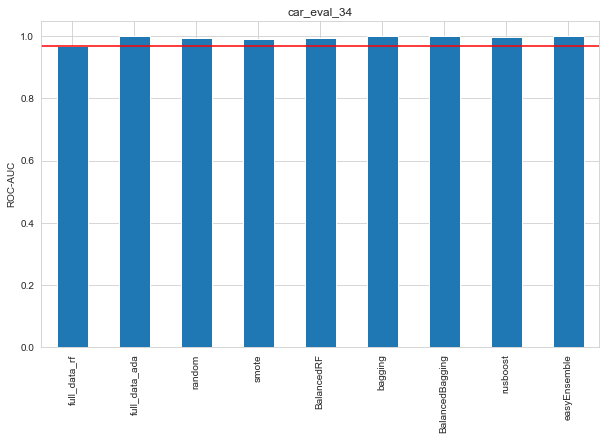

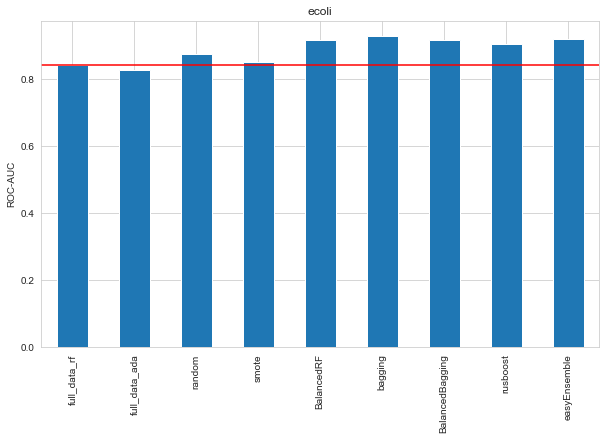

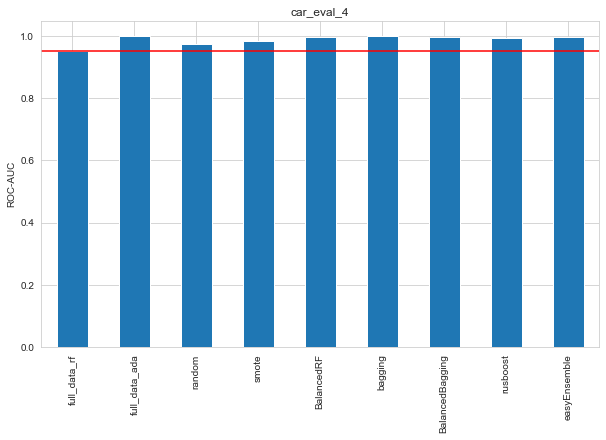

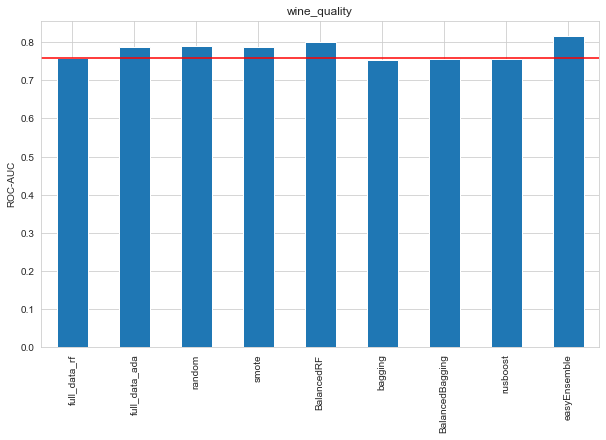

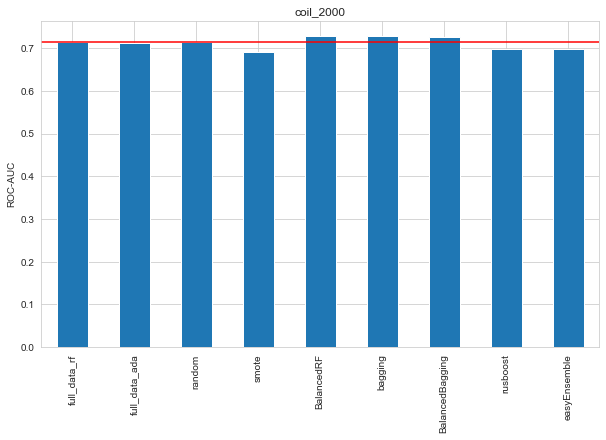

In [27]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data_rf"],color="r")
    plt.show()

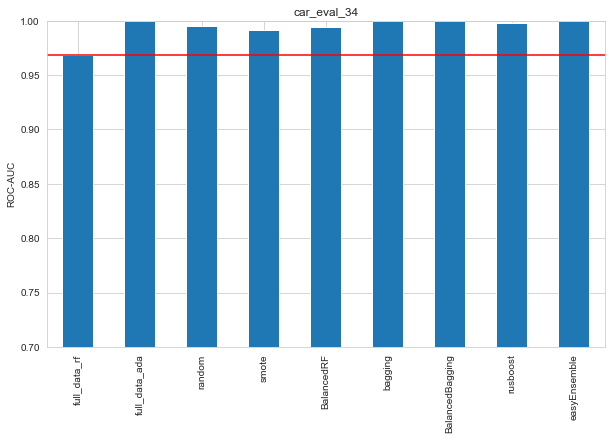

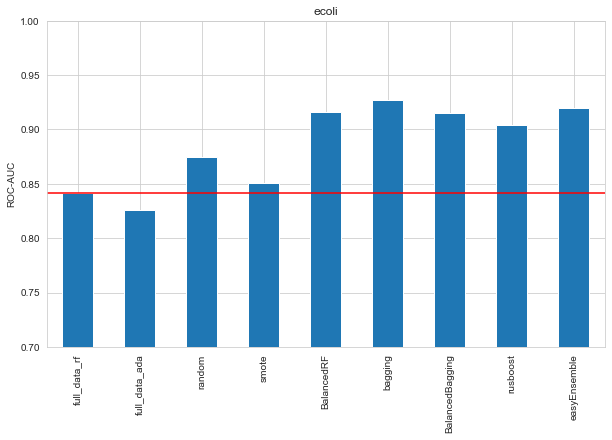

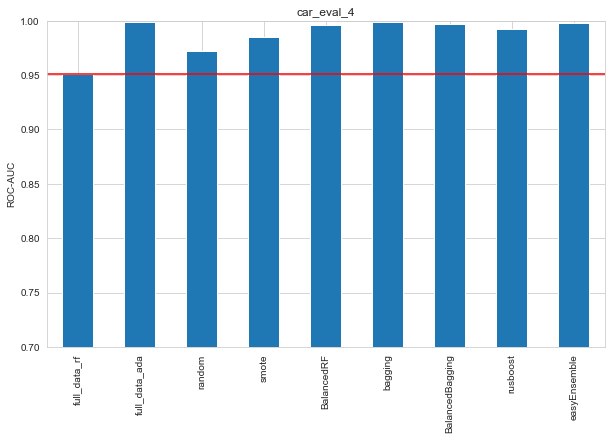

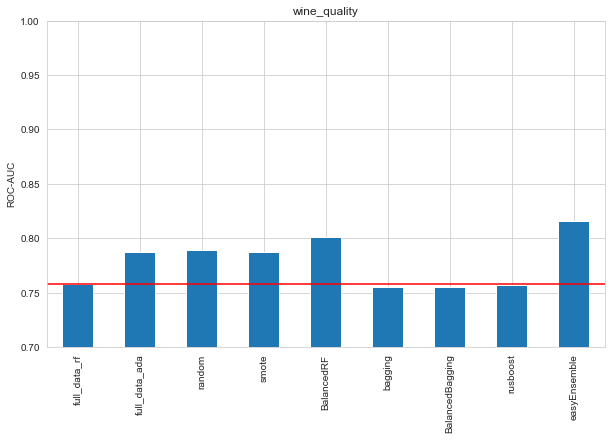

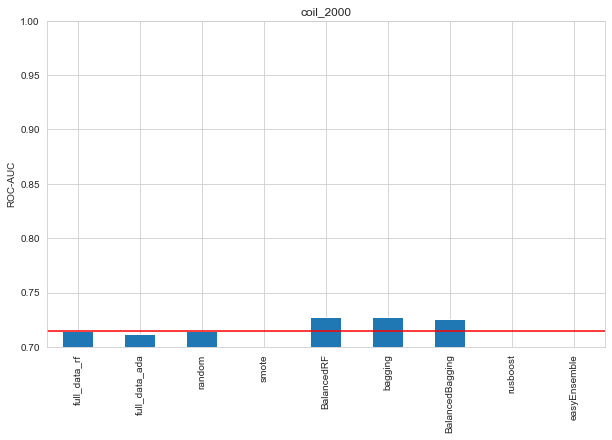

In [28]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.ylim(0.7,1)
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data_rf"],color="r")
    plt.show()